In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Spam Classification using Word2Vec and Logistic Regression
# This notebook loads cleaned_dataset, performs EDA, balances the dataset,
# creates sentence embeddings using Word2Vec, and trains a logistic regression model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")


Libraries imported successfully!


In [5]:
# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/uni_things/cleaned_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1683399, 13)

First few rows:


,reviewerID,asin,reviewerName,helpful,review,overall,summary,category,is_spam,clean_review,clean_summary,helpful_votes,total_votes
0,AJHS9ESNZETTE,0705394492,Amy,"[0, 0]",I love this book. I bought this one as a gift. It came very quickly and is as good as it was de...,5,Perfect,Home_and_Kitchen,1,i love this book. i bought this one as a gift. it came very quickly and is as good as it was de...,perfect,NaN,NaN
1,AE0MBLS6C1K2U,0740794108,"R. Wise ""R.Wise""","[0, 0]",This comic plate came shipped in a sturdy package. My wife put this on her Wish List and I boug...,5,Wonderful piece of art.,Home_and_Kitchen,1,this comic plate came shipped in a sturdy package. my wife put this on her wish list and i boug...,wonderful piece of art.,NaN,NaN
2,A2R0WKJVXO0GC8,0974889172,James C. Wright,"[0, 0]",A friend of mine had this and I ended up messing with it half the night at his house. It's a ve...,5,Love this!,Home_and_Kitchen,1,a friend of mine had this and i ended up messing with it half the night at his house. it's a ve...,love this!,NaN,NaN
3,A3QKZV4SAGSRBB,0974889172,K. Khaydarov,"[0, 0]",Whether you've hit a block in your writing or you're just looking for something to fiddle with o...,5,Perfect Poetry,Home_and_Kitchen,1,whether you've hit a block in your writing or you're just looking for something to fiddle with o...,perfect poetry,NaN,NaN
4,A2HYWSEPWB1I1W,0974889172,R. Hill,"[0, 0]",We've had these sitting on our coffee table for over 20 years. It's a good way to break the ice...,5,fun thing,Home_and_Kitchen,1,we've had these sitting on our coffee table for over 20 years. it's a good way to break the ice...,fun thing,NaN,NaN


In [6]:
# 1. INITIAL DATA ANALYSIS

print("=" * 60)
print("1. INITIAL DATA ANALYSIS")
print("=" * 60)

# Basic information about the dataset
print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")

print("\nColumn Names and Data Types:")
print(df.dtypes)

print("\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0])

print("\nBasic Statistics:")
print(df.describe(include='all'))


1. INITIAL DATA ANALYSIS

Dataset Info:
Shape: (1683399, 13)
Rows: 1,683,399
Columns: 13

Column Names and Data Types:
reviewerID        object
asin              object
reviewerName      object
helpful           object
review            object
overall            int64
summary           object
category          object
is_spam            int64
clean_review      object
clean_summary     object
helpful_votes    float64
total_votes      float64
dtype: object

Missing Values:
reviewerName       6360
summary              23
clean_summary        44
helpful_votes    846360
total_votes      846360
dtype: int64

Basic Statistics:
           reviewerID        asin     reviewerName  helpful        review  \
count         1683399     1683399          1677039  1683399       1683399   
unique        1357232      199978          1005257     4096       1683117   
top     AJGU56YG8G1DQ  B005SUHPO6  Amazon Customer   [0, 0]  good product   
freq              265       17522            26818  1073728      

In [7]:
# Identify feature types
print("\nFeature Types Analysis:")
print("\nTextual Columns:")
textual_cols = ['review', 'summary', 'clean_review', 'clean_summary']
for col in textual_cols:
    if col in df.columns:
        print(f"  - {col}: {df[col].dtype}, Non-null: {df[col].notna().sum():,}")

print("\nCategorical Columns:")
categorical_cols = ['reviewerID', 'asin', 'reviewerName', 'category']
for col in categorical_cols:
    if col in df.columns:
        print(f"  - {col}: {df[col].dtype}, Unique values: {df[col].nunique():,}")

print("\nNumerical Columns:")
numerical_cols = ['overall', 'is_spam', 'helpful_votes', 'total_votes']
for col in numerical_cols:
    if col in df.columns:
        print(f"  - {col}: {df[col].dtype}, Range: [{df[col].min()}, {df[col].max()}]")

print("\nTarget Variable Distribution (is_spam):")
print(df['is_spam'].value_counts())
print(f"\nPercentage:")
print(df['is_spam'].value_counts(normalize=True) * 100)



Feature Types Analysis:

Textual Columns:
  - review: object, Non-null: 1,683,399
  - summary: object, Non-null: 1,683,376
  - clean_review: object, Non-null: 1,683,399
  - clean_summary: object, Non-null: 1,683,355

Categorical Columns:
  - reviewerID: object, Unique values: 1,357,232
  - asin: object, Unique values: 199,978
  - reviewerName: object, Unique values: 1,005,257
  - category: object, Unique values: 4

Numerical Columns:
  - overall: int64, Range: [1, 5]
  - is_spam: int64, Range: [0, 1]
  - helpful_votes: float64, Range: [0.0, 2506.0]
  - total_votes: float64, Range: [0.0, 2576.0]

Target Variable Distribution (is_spam):
is_spam
1    1310970
0     372429
Name: count, dtype: int64

Percentage:
is_spam
1    77.876368
0    22.123632
Name: proportion, dtype: float64


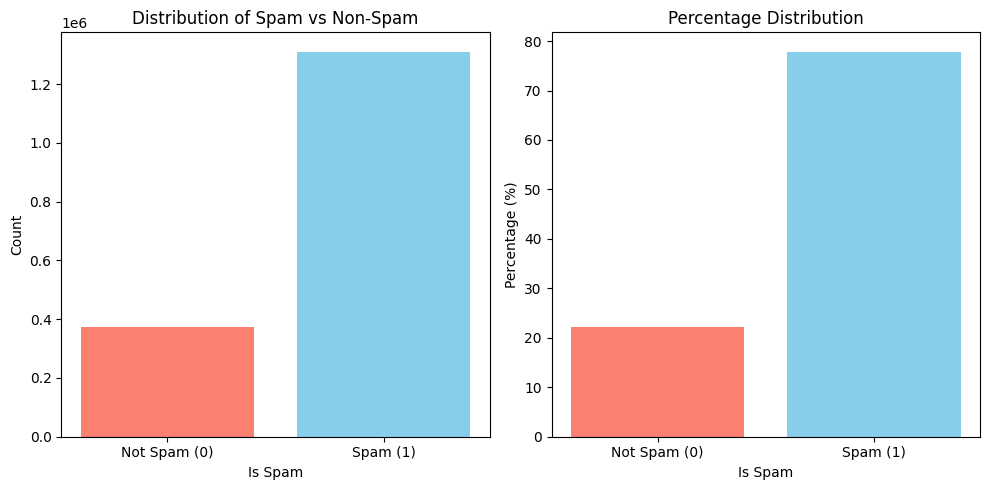

Spam: 1,310,970 (77.88%)
Not Spam: 372,429 (22.12%)


In [8]:
# Visualize target distribution
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
spam_counts = df['is_spam'].value_counts()
plt.bar(spam_counts.index, spam_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.title('Distribution of Spam vs Non-Spam')
plt.xticks([0, 1], ['Not Spam (0)', 'Spam (1)'])

plt.subplot(1, 2, 2)
spam_pct = df['is_spam'].value_counts(normalize=True) * 100
plt.bar(spam_pct.index, spam_pct.values, color=['skyblue', 'salmon'])
plt.xlabel('Is Spam')
plt.ylabel('Percentage (%)')
plt.title('Percentage Distribution')
plt.xticks([0, 1], ['Not Spam (0)', 'Spam (1)'])

plt.tight_layout()
plt.show()

print(f"Spam: {spam_counts.get(1, 0):,} ({spam_pct.get(1, 0):.2f}%)")
print(f"Not Spam: {spam_counts.get(0, 0):,} ({spam_pct.get(0, 0):.2f}%)")


In [9]:
# Analyze text length statistics
print("\nText Length Statistics:")

for col in ['review', 'summary', 'clean_review', 'clean_summary']:
    if col in df.columns:
        df[f'{col}_length'] = df[col].astype(str).str.len()
        print(f"\n{col}:")
        print(f"  Mean length: {df[f'{col}_length'].mean():.2f} characters")
        print(f"  Median length: {df[f'{col}_length'].median():.2f} characters")
        print(f"  Min length: {df[f'{col}_length'].min()} characters")
        print(f"  Max length: {df[f'{col}_length'].max()} characters")



Text Length Statistics:

review:
  Mean length: 346.53 characters
  Median length: 209.00 characters
  Min length: 1 characters
  Max length: 30804 characters

summary:
  Mean length: 21.21 characters
  Median length: 18.00 characters
  Min length: 1 characters
  Max length: 318 characters

clean_review:
  Mean length: 346.45 characters
  Median length: 209.00 characters
  Min length: 1 characters
  Max length: 30804 characters

clean_summary:
  Mean length: 21.21 characters
  Median length: 18.00 characters
  Min length: 1 characters
  Max length: 318 characters


2. BALANCING THE DATASET

Before balancing:
  Spam (1): 1,310,970
  Not Spam (0): 372,429
  Ratio (Not Spam:Spam): 0.28:1

After balancing:
  Spam (1): 372,429
  Not Spam (0): 372,429
  Ratio (Not Spam:Spam): 1.00:1

Balanced dataset shape: (744858, 17)


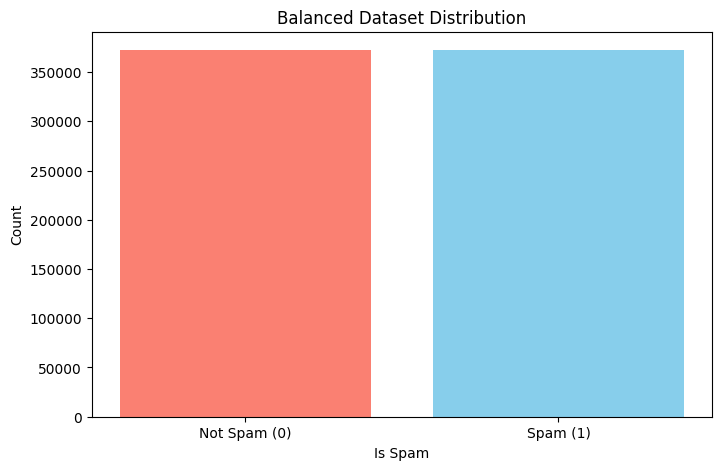

In [10]:
# 2. BALANCE THE DATASET (Remove excess not spam)

print("=" * 60)
print("2. BALANCING THE DATASET")
print("=" * 60)

# Check current distribution
spam_count = df['is_spam'].sum()
not_spam_count = (df['is_spam'] == 0).sum()

print(f"\nBefore balancing:")
print(f"  Spam (1): {spam_count:,}")
print(f"  Not Spam (0): {not_spam_count:,}")
print(f"  Ratio (Not Spam:Spam): {not_spam_count/spam_count:.2f}:1")

# Get spam and not spam dataframes
df_spam = df[df['is_spam'] == 1].copy()
df_not_spam = df[df['is_spam'] == 0].copy()

# Sample the majority class to match the minority class count
# If not_spam is more than spam, sample not_spam to match spam count
np.random.seed(42)
if not_spam_count > spam_count:
    df_not_spam_balanced = df_not_spam.sample(n=spam_count, random_state=42)
    df_spam_balanced = df_spam.copy()
else:
    # If spam is more than not_spam (unlikely), sample spam to match not_spam count
    df_spam_balanced = df_spam.sample(n=not_spam_count, random_state=42)
    df_not_spam_balanced = df_not_spam.copy()

# Combine balanced datasets
df_balanced = pd.concat([df_spam_balanced, df_not_spam_balanced], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nAfter balancing:")
spam_count_balanced = df_balanced['is_spam'].sum()
not_spam_count_balanced = (df_balanced['is_spam'] == 0).sum()
print(f"  Spam (1): {spam_count_balanced:,}")
print(f"  Not Spam (0): {not_spam_count_balanced:,}")
print(f"  Ratio (Not Spam:Spam): {not_spam_count_balanced/spam_count_balanced:.2f}:1")
print(f"\nBalanced dataset shape: {df_balanced.shape}")

# Visualize balanced distribution
plt.figure(figsize=(8, 5))
balanced_counts = df_balanced['is_spam'].value_counts()
plt.bar(balanced_counts.index, balanced_counts.values, color=['skyblue', 'salmon'])
plt.xlabel('Is Spam')
plt.ylabel('Count')
plt.title('Balanced Dataset Distribution')
plt.xticks([0, 1], ['Not Spam (0)', 'Spam (1)'])
plt.show()


In [12]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 52.2 MB/s eta 0:00:00


In [20]:
# 3. CREATE SENTENCE EMBEDDINGS USING WORD2VEC

print("=" * 60)
print("3. CREATING SENTENCE EMBEDDINGS WITH WORD2VEC")
print("=" * 60)

from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
import nltk
from nltk.tokenize import word_tokenize
import re

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    try:
        nltk.download('punkt_tab', quiet=True)
    except:
        # Fallback for older NLTK versions
        nltk.download('punkt', quiet=True)


# Prepare text data for Word2Vec
# We'll use clean_review and clean_summary as they are already cleaned
print("\nPreparing text data for Word2Vec...")

# Combine clean_review and clean_summary for training Word2Vec
# Use clean_review as primary text feature
text_column = 'clean_review'  # Using clean_review as the main textual feature

# Tokenize the text
def tokenize_text(text):
    """Tokenize text into words"""
    if pd.isna(text):
        return []
    text = str(text).lower()
    # Remove special characters but keep spaces
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove empty tokens
    tokens = [t for t in tokens if len(t) > 1]
    return tokens

print(f"Tokenizing {text_column} column...")
tokenized_sentences = df_balanced[text_column].apply(tokenize_text).tolist()

# Filter out empty sentences and keep track of valid indices
valid_indices = [i for i, s in enumerate(tokenized_sentences) if len(s) > 0]
tokenized_sentences = [tokenized_sentences[i] for i in valid_indices]

# Filter df_balanced to match the valid tokenized sentences
df_balanced_filtered = df_balanced.iloc[valid_indices].reset_index(drop=True)

print(f"Number of tokenized sentences: {len(tokenized_sentences):,}")
print(f"Sample tokenized sentence: {tokenized_sentences[0][:10]}...")


3. CREATING SENTENCE EMBEDDINGS WITH WORD2VEC

Preparing text data for Word2Vec...
Tokenizing clean_review column...
Number of tokenized sentences: 744,845
Sample tokenized sentence: ['was', 'able', 'to', 'successfully', 'install', 'the', 'screen', 'protector', 'myself', 'without']...


In [21]:
# Train Word2Vec model
print("\nTraining Word2Vec model...")

# Word2Vec parameters
vector_size = 100  # Dimension of word embeddings
window = 5         # Context window size
min_count = 2      # Minimum word frequency
workers = 4        # Number of worker threads
sg = 0             # 0 for CBOW, 1 for skip-gram

word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    sg=sg,
    epochs=10,
    seed=42
)

print(f"Word2Vec model trained!")
print(f"Vocabulary size: {len(word2vec_model.wv.key_to_index):,}")
print(f"Embedding dimension: {vector_size}")

# Show some example words
print(f"\nSample words in vocabulary:")
sample_words = list(word2vec_model.wv.key_to_index.keys())[:10]
print(sample_words)



Training Word2Vec model...
Word2Vec model trained!
Vocabulary size: 152,243
Embedding dimension: 100

Sample words in vocabulary:
['the', 'it', 'and', 'to', 'is', 'this', 'of', 'for', 'my', 'in']


In [22]:
# Create sentence embeddings by averaging word vectors
def get_sentence_embedding(sentence_tokens, model, vector_size):
    """Get sentence embedding by averaging word vectors"""
    # Get word vectors for tokens that exist in the model
    word_vectors = [model.wv[word] for word in sentence_tokens if word in model.wv.key_to_index]

    if len(word_vectors) == 0:
        # Return zero vector if no words found
        return np.zeros(vector_size)

    # Average the word vectors
    return np.mean(word_vectors, axis=0)

print("Creating sentence embeddings...")

# Create embeddings for all sentences
sentence_embeddings = []
for tokens in tokenized_sentences:
    embedding = get_sentence_embedding(tokens, word2vec_model, vector_size)
    sentence_embeddings.append(embedding)

# Convert to numpy array
X_embeddings = np.array(sentence_embeddings)
# Use the filtered dataframe to ensure matching lengths
y = df_balanced_filtered['is_spam'].values

print(f"Sentence embeddings shape: {X_embeddings.shape}")
print(f"Target shape: {y.shape}")
print(f"Embedding sample (first 10 dimensions): {X_embeddings[0][:10]}")


Creating sentence embeddings...
Sentence embeddings shape: (744845, 100)
Target shape: (744845,)
Embedding sample (first 10 dimensions): [ 1.07037997  1.11737621  1.10592711  0.15771358 -1.33899283  1.16865981
 -0.36857602  0.27133715 -1.75723767  1.30676162]


In [23]:
# 4. FIT LOGISTIC REGRESSION MODEL

print("=" * 60)
print("4. FITTING LOGISTIC REGRESSION MODEL")
print("=" * 60)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"\nTraining set distribution:")
print(f"  Spam: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.2f}%)")
print(f"  Not Spam: {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"\nTest set distribution:")
print(f"  Spam: {y_test.sum():,} ({y_test.sum()/len(y_test)*100:.2f}%)")
print(f"  Not Spam: {(y_test==0).sum():,} ({(y_test==0).sum()/len(y_test)*100:.2f}%)")


4. FITTING LOGISTIC REGRESSION MODEL
Training set shape: (595876, 100)
Test set shape: (148969, 100)

Training set distribution:
  Spam: 297,937 (50.00%)
  Not Spam: 297,939 (50.00%)

Test set distribution:
  Spam: 74,484 (50.00%)
  Not Spam: 74,485 (50.00%)


In [24]:
# Train Logistic Regression model
print("\nTraining Logistic Regression model...")

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    solver='lbfgs',  # Good for small to medium datasets
    class_weight='balanced'  # Handle any remaining class imbalance
)

lr_model.fit(X_train, y_train)
print("Model trained successfully!")

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Get prediction probabilities for ROC curve
y_train_proba = lr_model.predict_proba(X_train)[:, 1]
y_test_proba = lr_model.predict_proba(X_test)[:, 1]



Training Logistic Regression model...
Model trained successfully!


In [25]:
# Evaluate the model
print("\n" + "=" * 60)
print("MODEL EVALUATION")
print("=" * 60)

# Training set metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_auc = roc_auc_score(y_train, y_train_proba)

print("\nTraining Set Performance:")
print(f"  Accuracy: {train_accuracy:.4f}")
print(f"  ROC-AUC: {train_auc:.4f}")

# Test set metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_proba)

print("\nTest Set Performance:")
print(f"  Accuracy: {test_accuracy:.4f}")
print(f"  ROC-AUC: {test_auc:.4f}")

# Detailed classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Not Spam', 'Spam']))



MODEL EVALUATION

Training Set Performance:
  Accuracy: 0.8299
  ROC-AUC: 0.9091

Test Set Performance:
  Accuracy: 0.8301
  ROC-AUC: 0.9091

Classification Report (Test Set):
              precision    recall  f1-score   support

    Not Spam       0.82      0.84      0.83     74485
        Spam       0.84      0.82      0.83     74484

    accuracy                           0.83    148969
   macro avg       0.83      0.83      0.83    148969
weighted avg       0.83      0.83      0.83    148969



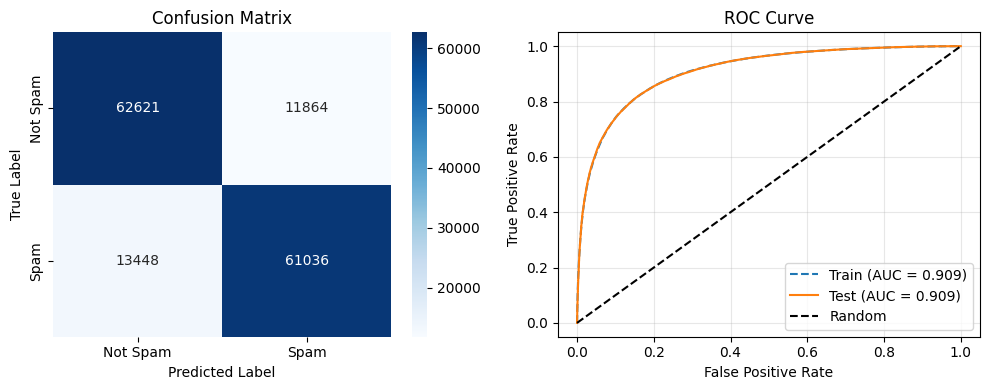


Confusion Matrix:
  True Negatives (Not Spam → Not Spam): 62621
  False Positives (Not Spam → Spam): 11864
  False Negatives (Spam → Not Spam): 13448
  True Positives (Spam → Spam): 61036


In [26]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spam', 'Spam'],
            yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve
plt.subplot(1, 2, 2)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {train_auc:.3f})', linestyle='--')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix:")
print(f"  True Negatives (Not Spam → Not Spam): {cm[0, 0]}")
print(f"  False Positives (Not Spam → Spam): {cm[0, 1]}")
print(f"  False Negatives (Spam → Not Spam): {cm[1, 0]}")
print(f"  True Positives (Spam → Spam): {cm[1, 1]}")



FEATURE IMPORTANCE ANALYSIS

Coefficient Statistics:
  Mean: 0.0027
  Std: 0.4543
  Min: -1.1600
  Max: 1.1963


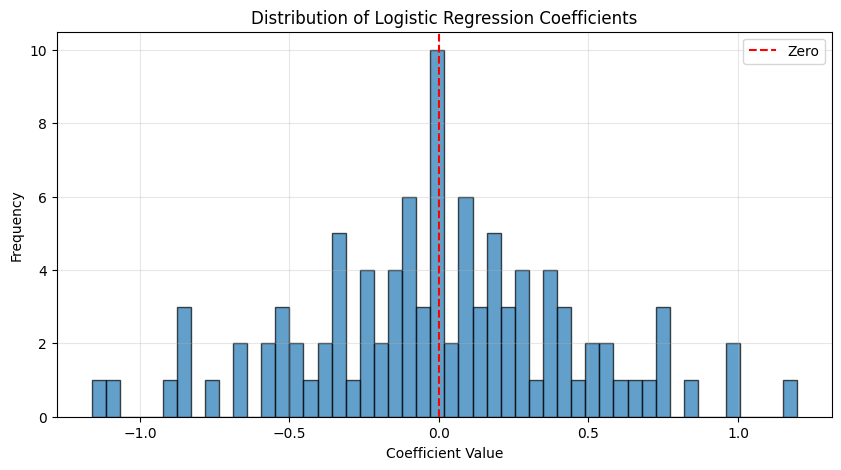


Model Summary:
  Number of features: 100
  Intercept: 0.8393


In [27]:
# Feature importance analysis (coefficients from logistic regression)
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get coefficients
coefficients = lr_model.coef_[0]

print(f"\nCoefficient Statistics:")
print(f"  Mean: {coefficients.mean():.4f}")
print(f"  Std: {coefficients.std():.4f}")
print(f"  Min: {coefficients.min():.4f}")
print(f"  Max: {coefficients.max():.4f}")

# Plot coefficient distribution
plt.figure(figsize=(10, 5))
plt.hist(coefficients, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.title('Distribution of Logistic Regression Coefficients')
plt.axvline(x=0, color='red', linestyle='--', label='Zero')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\nModel Summary:")
print(f"  Number of features: {len(coefficients)}")
print(f"  Intercept: {lr_model.intercept_[0]:.4f}")


In [28]:
# Summary
print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"\n1. Dataset loaded: {df.shape[0]:,} rows, {df.shape[1]} columns")
print(f"2. Dataset balanced: {df_balanced.shape[0]:,} rows (50% spam, 50% not spam)")
print(f"3. Word2Vec model: {len(word2vec_model.wv.key_to_index):,} words, {vector_size}D embeddings")
print(f"4. Logistic Regression:")
print(f"   - Training Accuracy: {train_accuracy:.4f}")
print(f"   - Test Accuracy: {test_accuracy:.4f}")
print(f"   - Test ROC-AUC: {test_auc:.4f}")
print("\nModel training completed successfully!")



SUMMARY

1. Dataset loaded: 1,683,399 rows, 17 columns
2. Dataset balanced: 744,858 rows (50% spam, 50% not spam)
3. Word2Vec model: 152,243 words, 100D embeddings
4. Logistic Regression:
   - Training Accuracy: 0.8299
   - Test Accuracy: 0.8301
   - Test ROC-AUC: 0.9091

Model training completed successfully!
